# 1
## 1.1

In [0]:
import torch
from torch.utils.data import Dataset, DataLoader

In [0]:
import numpy as np


def sample_data():
    count = 10000
    rand = np.random.RandomState(0)
    a = 0.3 + 0.1 * rand.randn(count)
    b = 0.8 + 0.05 * rand.randn(count)
    mask = rand.rand(count) < 0.5
    samples = np.clip(a * mask + b * (1 - mask), 0.0, 1.0)
    return np.digitize(samples, np.linspace(0.0, 1.0, 100))

def sample_validation():
    count = 2000
    rand = np.random.RandomState(8888)
    a = 0.3 + 0.1 * rand.randn(count)
    b = 0.8 + 0.05 * rand.randn(count)
    mask = rand.rand(count) < 0.5
    samples = np.clip(a * mask + b * (1 - mask), 0.0, 1.0)
    return np.digitize(samples, np.linspace(0.0, 1.0, 100))

In [0]:
dataset = sample_data()
X_train, test = torch.tensor(dataset[:8000]), torch.tensor(dataset[8000:])
validation = torch.tensor(sample_validation())

In [0]:
from torch.nn import functional as F

class SoftmaxModel(torch.nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.num_labels = num_labels
        self.thetas = torch.zeros(num_labels, requires_grad=True)

    def forward(self):
        return F.log_softmax(self.thetas, dim=0)

    def parameters(self):
        return [self.thetas]

In [0]:
model = SoftmaxModel(100)

def train(batch_size, num_epochs):
    loss_function = torch.nn.NLLLoss(reduction='mean')
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    trainLoader = DataLoader(X_train, batch_size=batch_size)
    num_batches = len(trainLoader)
    step = 0
    valLoss = []
    xVal = []
    trainLoss = []
    xTrain = []
    for epoch in range(num_epochs):
        for i, batch in enumerate(trainLoader):
            step += 1
            probs = model()
            probs = probs.repeat(batch.size()[0], 1)
            loss = loss_function(probs, batch)
            trainLoss.append(np.log2(float(loss)))
            xTrain.append(step)
            loss.backward()
            optimizer.step()
            model.zero_grad()
            with torch.no_grad():
                probs = model()
                probs = probs.repeat(validation.size()[0], 1)
                loss = loss_function(probs, validation)
                xVal.append(step)
                valLoss.append(np.log2(float(loss)))
    return valLoss, xVal, trainLoss, xTrain

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()


def plotLosses(valLoss, xVal, trainLoss, trainVal):
    fig, ax = plt.subplots()
    ax.plot(trainVal, trainLoss, label='train')
    ax.plot(xVal, valLoss, label='validation')
    plt.legend()
    plt.show()


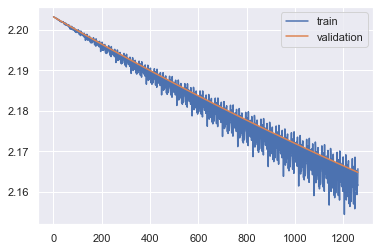

In [0]:
plotLosses(*train(128, 20))

## 1.2

In [0]:
def plotDist(p, title):
    fig, ax = plt.subplots()
    ax.set(xlabel='x', ylabel='p',title=title)
    ax.bar(np.arange(100), p)
    plt.show()

In [0]:
def sampleModel():
    probs = model().exp().detach().numpy()
    sample = np.zeros(100)
    for i in np.random.choice(100, 1000, p=probs):
        sample[i] += 1
    return sample / 1000

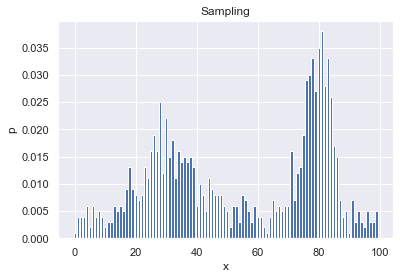

In [0]:
plotDist(sampleModel(), 'Sampling')

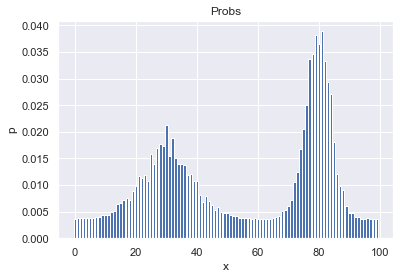

In [0]:
plotDist(model().exp().detach().numpy(), 'Probs')

In [0]:
def sampleData():
    sample = np.zeros(100)
    for i in dataset:
        sample[i] += 1
    return sample / 1000

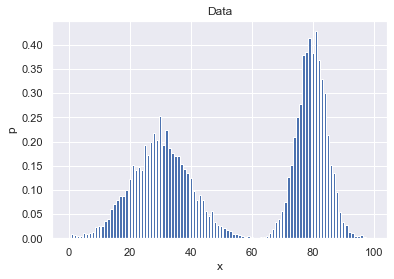

In [0]:
plotDist(sampleData(), 'Data')

As we can see there is two spikes coming from a and b from data distribution with spike in b being more precise due to less deviation ( $0.05$ compare $0.1$). Probabilities bar plot is more smooth than sampling as expected. We also see that there are gaps between points a and in data distribution because our distribution cannot reach some of the numbers, yet model still has probability for these zero mass points.

# 2

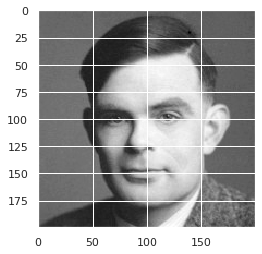

In [0]:
distribution = np.load('../distribution.npy')
plt.imshow(distribution, cmap='gray')

## 2.1

In [0]:
from torch import nn

class MLPModel(nn.Module):
    
    def __init__(self, in_dim, num_labels):
        super().__init__()
        
        self.in_dim = in_dim
        self.fc1 = nn.Sequential(nn.Linear(in_dim, num_labels),
                                 nn.ReLU(),
                                 nn.Linear(num_labels, num_labels))
        self.fc2 = nn.Sequential(nn.Linear(in_dim, num_labels),
                                 nn.ReLU(),
                                 nn.Linear(num_labels, num_labels))
    
    def forward(self, x1, x2):
        x1_onehot = torch.zeros(x1.shape[0], self.in_dim)
        x1_onehot.scatter_(1, x1.view(-1, 1).long(), 1)
        
        prob1 = F.softmax(self.fc1(torch.ones_like(x1_onehot)), dim=1).gather(1, x1.view(-1, 1).long())
        prob2 = F.softmax(self.fc2(x1_onehot), dim=1).gather(1, x2.view(-1, 1).long())
        return prob1 * prob2

In [0]:
def train(model, trainLoader, valLoader, num_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    step = 0
    valLoss = []
    xVal = []
    trainLoss = []
    xTrain = []
    for epoch in range(num_epochs):
        for i, (x1, x2) in enumerate(trainLoader):
            step += 1
            probs = model(x1.float(), x2.float())
            loss = -probs.log().mean()
            trainLoss.append(float(loss))
            xTrain.append(step)
            loss.backward()
            optimizer.step()
            model.zero_grad()
            if (i % 20) == 0:
             with torch.no_grad():
                for (x1, x2) in valLoader: 
                    probs = model(x1.float(), x2.float())
                    loss = -probs.log().mean()
                    xVal.append(step)
                    valLoss.append(float(loss))
    return valLoss, xVal, trainLoss, xTrain

In [0]:
def sampleData(n):
    samples = np.random.choice(distribution.size, n, p=distribution.ravel())
    x1 = samples // distribution.shape[0]
    x2 = samples % distribution.shape[0]
    return list(zip(x1, x2))

In [0]:
data = sampleData(100000)
valData = sampleData(2000)

In [0]:
X_train = data[:-20000]
test = data[-20000:]
trainLoader = torch.utils.data.DataLoader(X_train, batch_size=1000, shuffle=True)
valLoader = torch.utils.data.DataLoader(valData, batch_size=2000, shuffle=True)

In [0]:
model = MLPModel(200, 200)

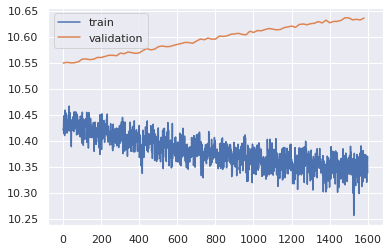

In [0]:
plotLosses(*train(model, trainLoader, valLoader, 20))

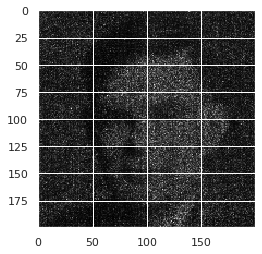

In [0]:
x = np.arange(distribution.size)
x1 = x // distribution.shape[0]
x2 = x % distribution.shape[0]
probs = model(torch.from_numpy(x1).reshape(-1, 1), torch.from_numpy(x2).reshape(-1, 1)).detach().numpy()
plt.imshow(probs.reshape(200, 200), cmap='gray')

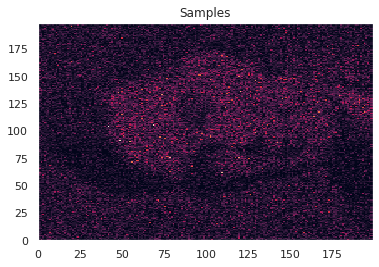

In [0]:
samples = np.random.choice(distribution.size, 100000, p=probs.reshape(-1))
x1 = samples // distribution.shape[0]
x2 = samples % distribution.shape[0]

plt.hist2d(x1, x2, bins=200)
plt.title('Samples')
plt.show()

## 2.2

In [0]:
def zero_grad(self, grad_input, grad_output):
    return grad_input[0], grad_input[1], self.mask * grad_input[2]


class MaskedLinear(torch.nn.Linear):
    
    def __init__(self, in_features, out_features):
        super().__init__(in_features, out_features)
        
        self.handle = self.register_backward_hook(zero_grad) 
        
    def forward(self, input, mask):
        self.mask = mask
        return F.linear(input, mask * self.weight, self.bias)


class MADE(nn.Module):
    
    def __init__(self, in_dim, num_labels):
        super().__init__()
        
        self.in_dim = in_dim
        self.num_labels = num_labels
        self.fc1 = MaskedLinear(in_dim, num_labels)
        self.fc2 = MaskedLinear(num_labels, num_labels)
        self.fc3 = MaskedLinear(num_labels, num_labels)
        
    def forward(self, x1, x2, use_mask=True):
        one_hot = torch.zeros(x1.shape[0], self.in_dim)
        one_hot.scatter_(1, x1.view(-1, 1).long(), 1)
        
        x = self.fc1(one_hot, torch.ones(1))
        x = self.fc2(F.relu(x), torch.ones(1))
        self.threshold2 = torch.FloatTensor(self.fc2.weight.shape).uniform_(float(self.fc2.weight.min()),
                                                                            float(self.fc2.weight.max())).detach()
        self.mask2 = (self.threshold2 <= self.fc2.weight).float().detach() if use_mask else 1
        x = self.fc3(F.relu(x), self.mask2)
        x = F.softmax(x.view(-1, 2, 200), dim=2)
        return x.gather(2, torch.cat((x1.view(-1, 1).long(), x2.view(-1, 1).long()), dim=1).view(-1, 2, 1)).prod(1)

In [0]:
model = MADE(200, 400)
torch.autograd.set_detect_anomaly(True)

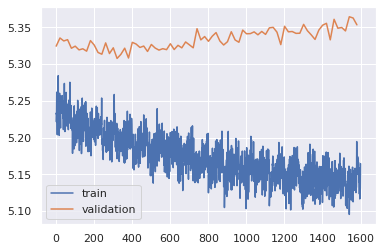

In [0]:
plotLosses(*train(model, trainLoader, valLoader, 20))

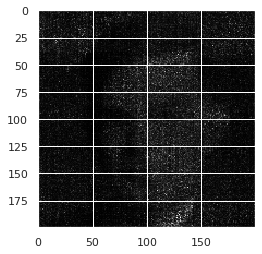

In [0]:
x = np.arange(distribution.size)
x1 = x // distribution.shape[0]
x2 = x % distribution.shape[0]
probs = model(torch.from_numpy(x1).reshape(-1, 1), torch.from_numpy(x2).reshape(-1, 1), False).detach().numpy()
plt.imshow(probs.reshape(200, 200), cmap='gray')

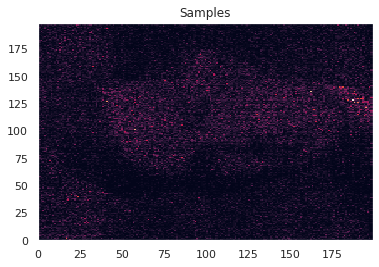

In [0]:
samples = np.random.choice(distribution.size, 100000, p=probs.reshape(-1) / probs.sum())
x1 = samples // distribution.shape[0]
x2 = samples % distribution.shape[0]

plt.hist2d(x1, x2, bins=200)
plt.title('Samples')
plt.show()

## 3

In [0]:
!pip install PyDrive

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
download = drive.CreateFile({'id': '1hm077GxmIBP-foHxiPtTxSNy371yowk2'})
download.GetContentFile('mnist-hw1.pkl')

In [0]:
import pickle

with open('mnist-hw1.pkl', 'rb') as f:
    mnist = pickle.load(f)

In [0]:
X_train = mnist['train']
X_val = mnist['test']

In [0]:
trainLoader = torch.utils.data.DataLoader(X_train, batch_size=128, shuffle=True)
valLoader = torch.utils.data.DataLoader(X_val[:2000], batch_size=128, shuffle=True)

In [0]:
def zero_grad(self, grad_input, grad_output):
    return grad_input[0], self.mask * grad_input[1], grad_input[2]


class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, in_channels, out_channels, kernel_size=1, padding=0):
        super().__init__(in_channels, out_channels, kernel_size, padding=padding)
      
        self.mask = torch.ones(self.weight.shape).cuda()
        self.mask[:, :, kernel_size // 2, kernel_size // 2 + (mask_type == 'B'):] = 0
        self.mask[:, :, kernel_size // 2 + 1:] = 0
        self.handle = self.register_backward_hook(zero_grad) 

    def forward(self, x):
        self.weight.data *= self.mask
        return super().forward(x)

In [0]:
class ResBlock(nn.Module):
    
    def __init__(self, in_dim=16):
        super().__init__()
        
        self.cnn = nn.Sequential(MaskedConv2d('B', in_dim, in_dim // 2),
                                 nn.ReLU(),
                                 MaskedConv2d('B', in_dim // 2, in_dim // 2, kernel_size=3, padding=1),
                                 nn.ReLU(),
                                 MaskedConv2d('B', in_dim // 2, in_dim),
                                 nn.ReLU())

    def forward(self, x):
        return self.cnn(x) + x

In [0]:
class PixelCNN(nn.Module):
    
    def __init__(self, in_dim=16, out_dim=3, num_blocks=12):
        super().__init__()

        self.model = nn.Sequential(MaskedConv2d('A', 3, in_dim, kernel_size=7, padding=3),
                                   *[ResBlock() for i in range(num_blocks)],
                                   nn.ReLU(),
                                   MaskedConv2d('B', in_dim, in_dim, kernel_size=1),
                                   nn.ReLU(),
                                   MaskedConv2d('B', in_dim, out_dim * 4, kernel_size=1))

    def forward(self, x):
        out = self.model(x)
        out = out.reshape(x.shape[0], x.shape[1], 4, x.shape[2], x.shape[3]).permute(0, 1, 3, 4, 2)
        
        return F.softmax(out, dim=-1)

In [0]:
def train(model, trainLoader, valLoader, num_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    step = 0
    valLoss = []
    xVal = []
    trainLoss = []
    xTrain = []
    for epoch in range(num_epochs):
        for i, batch in enumerate(trainLoader):
            step += 1
            x = batch.cuda().float().transpose(1, 3)
            probs = model(x).gather(-1, x.unsqueeze(-1).long())
            loss = -probs.log().mean()
            trainLoss.append(float(loss))
            xTrain.append(step)
            loss.backward()
            optimizer.step()
            model.zero_grad()
            if (i % 30) == 0:
             with torch.no_grad():
                loss = 0
                xVal.append(step)
                cnt = 0
                for val_batch in valLoader:
                    cnt += 1
                    x = val_batch.cuda().float().transpose(1, 3)
                    probs = model(x).gather(-1, x.unsqueeze(-1).long())
                    loss = -probs.log().mean()
                    loss += float(loss)
                valLoss.append(loss / cnt)
    return valLoss, xVal, trainLoss, xTrain

In [222]:
model = PixelCNN().cuda()
torch.autograd.set_detect_anomaly(True)

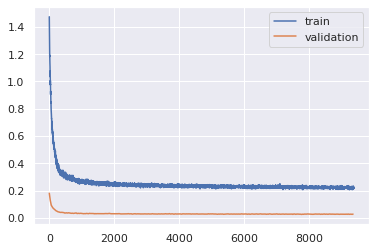

In [223]:
plotLosses(*train(model, trainLoader, valLoader, 20))

In [0]:
def sample(model, n):
    model.eval()
    samples = torch.ones((n, 3, 28, 28)).cuda()
    with torch.no_grad():
        for y in range(28):
            for x in range(28):
                for c in range(3):
                    probs = model(samples).cpu().numpy()
                    for i in range(n):
                       samples[i, c, y, x] = np.random.choice(4, p=probs[i, c, y, x])
    return samples

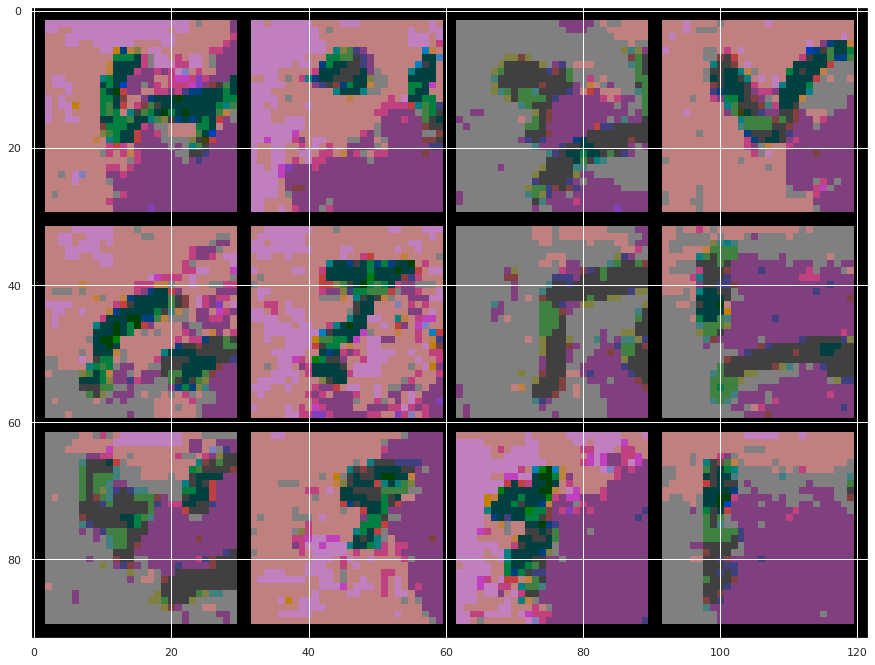

In [332]:
import torchvision

samples = sample(model, 12)
image = torchvision.utils.make_grid(samples.long(), nrow=3).cpu().numpy()
plt.figure(figsize=[15, 15])
plt.imshow(np.transpose(image, (2, 1, 0)) * 64)

In [0]:
def plotReceptiveField(model):
    x = torch.from_numpy(X_val[0]).unsqueeze(0).cuda().transpose(1, 3).float().requires_grad_(True)
    
    probs = model(x)[:, 0, 14, 14].gather(-1, x[:, 0, 14, 14].unsqueeze(-1).long())
    loss = -probs.log().mean()
    loss.backward()
    grad = x.grad.squeeze(0)

    image, inds = grad.abs().max(0)
    plt.imshow(image.cpu())

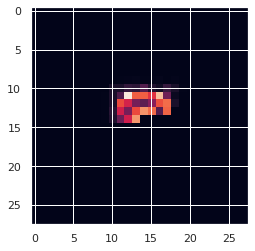

In [323]:
plotReceptiveField(PixelCNN().cuda())